## TODO

1. Pick a dataset -- Used the flower recognition dataset in Kaggle.com/datasets
2. Download the dataset
3. Import the dataset using PyTorch
4. Explore the dataset
5. Prepare the dataset for training


## Download the dataset

Using the "opendatasets" and download the flower datasets from Kaggle. 

The link to the datasets is as below:

https://www.kaggle.com/datasets/alxmamaev/flowers-recognition


In [105]:
!pip install opendatasets --upgrade --quiet

In [106]:
import opendatasets as od

In [107]:
dataset_url = 'https://www.kaggle.com/datasets/alxmamaev/flowers-recognition'

In [108]:
od.download(dataset_url)

Skipping, found downloaded files in "./flowers-recognition" (use force=True to force download)


## Checking the directory of downloaded data from Kaggle

Using the listdir(dataset) method

In [109]:
data_dir = './flowers-recognition/flowers'

In [110]:
import os

In [111]:
os.listdir(data_dir)

['sunflower', 'tulip', 'rose', 'dandelion', 'daisy']

## Import the dataset into Pytorch

Use the ImageFolder class from torchvision

In [112]:
from torchvision.datasets import ImageFolder

In [113]:
dataset = ImageFolder(data_dir)

In [114]:
len(dataset)

4317

In [115]:


dataset.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [116]:
for cls in os.listdir(data_dir):
  print(cls, ':', len(os.listdir(data_dir + "/" + cls)))

sunflower : 733
tulip : 984
rose : 784
dandelion : 1052
daisy : 764


In [117]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=320x263 at 0x7FD23FCE3D10>, 0)

In [118]:
import matplotlib.pyplot as plt
%matplotlib inline

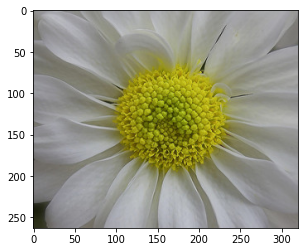

In [119]:
img,label = dataset[0]
plt.imshow(img)

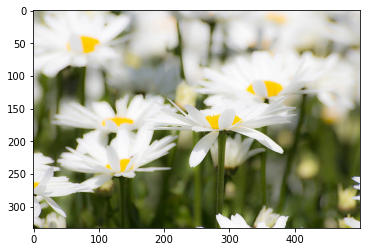

In [120]:
img,label = dataset[100]
plt.imshow(img)

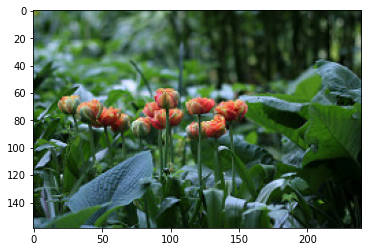

In [121]:
img,label = dataset[3500]
plt.imshow(img)

## Transforming data

In deep learning we need all the data to be in the same size. 

In [122]:
import torchvision.transforms as tt

dataset = ImageFolder(data_dir,tt.Compose([tt.Resize(224),tt.RandomCrop(224),tt.ToTensor()]))

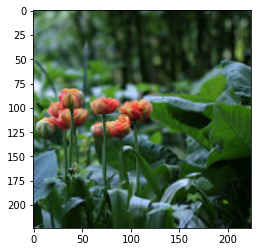

In [123]:
img,label = dataset[3500]
plt.imshow(img.permute((1,2,0)))

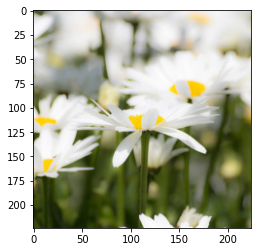

In [124]:
img,label = dataset[100]
plt.imshow(img.permute((1,2,0)))

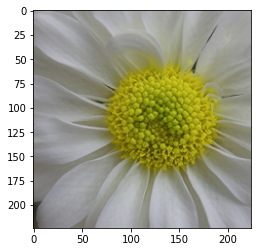

In [125]:
img,label = dataset[0]
plt.imshow(img.permute((1,2,0)))

## Splitting Data

using the random_split function to transform to training and Validation data

In [126]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset)- val_size

train_size,val_size

(3886, 431)

In [127]:
from torch.utils.data import random_split
train_ds, valid_ds = random_split(dataset,[train_size,val_size])
len(train_ds),len(valid_ds)

(3886, 431)

## Creating Data Loaders 

This is for training and validation to load the data in batches

In [128]:
from torch.utils.data import DataLoader

batch_size = 15

train_d1 = DataLoader(train_ds,
                      batch_size,shuffle = True, 
                      num_workers = 4, 
                      pin_memory=True )

val_d1 = DataLoader(valid_ds,
                    batch_size*2, 
                    num_workers=4,
                    pin_memory = True)

In [129]:
from torchvision.utils import make_grid

def show_batch(d1):
  for images, labels in d1:
    fig, ax = plt.subplots(figsize = (12,6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
    break

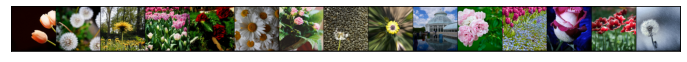

In [130]:
show_batch(train_d1)

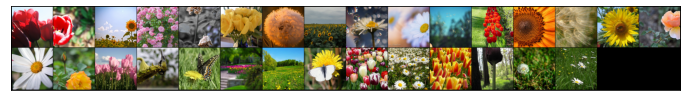

In [131]:
show_batch(val_d1)

## GPU Utility functions and classes

In [132]:
def get_default_device():
  """ Pick GPU if available, else CPU """
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data,device):
  """ move tensor(s) to chosen device """
  if isinstance(data, (list,tuple)):
    return [to_device(x,device) for x in data]
  return data.to(device, non_blocking = True)

class DeviceDataLoader():
  """ Wrap a dataloader to move data to a device"""
  def __init__(self,d1,device):
    self.d1 =d1
    self.device=device

  def __iter__(self):
    """ Yield a batch of data after moving it to device """
    for b in self.d1:
      yield to_device(b,self.device)

  def __len__(self):
    """ number of batches """
    return len(self.d1)


      



In [133]:
import torch
torch.cuda.is_available()

True

In [134]:
device = get_default_device()
device

device(type='cuda')

In [135]:
img,label = dataset[0]
img.device

device(type='cpu')

 move tensor(s) to chosen device 

In [136]:
img_gpu = to_device(img,device)
img_gpu.device

device(type='cuda', index=0)

Wrapping a dataloader to move data to a choosen device

In [137]:
train_d1 = DeviceDataLoader(train_d1,device)
val_d1 = DeviceDataLoader(val_d1,device)

## Model and Training Utilities

In [138]:
import torch.nn as nn
import torch.nn.functional as F


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

We'll use nn.Sequential to chain the layers and activations functions into a single network architecture.

In [139]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [140]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

Moving our model to the GPU

In [141]:
model = to_device(model, device)
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

## Training the **Model**

In [142]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [143]:
evaluate(model, val_d1)

RuntimeError: ignored

Using below hyperparameter to train the model

In [ ]:
import torch

num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = fit(num_epochs, lr, model, train_d1, val_d1, opt_func)

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
plot_accuracies(history)

In [144]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [145]:
plot_losses(history)

NameError: ignored

## Testing the model

In [146]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

NameError: ignored

In [147]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [148]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

NameError: ignored

In [149]:
img, label = test_dataset[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

NameError: ignored

In [150]:
img, label = test_dataset[6153]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

NameError: ignored

In [151]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

NameError: ignored